In [13]:
import sys
sys.path.append('../')

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

DATA_PATH = "/dust3r/masked_dust3r/data/jackal_training_data_0"

with open(os.path.join(DATA_PATH, "transforms.json"), "r") as f:
    transforms = json.load(f)

[[-114.9503541     0.77237233   56.7224849 ]
 [-114.9503541     0.77237233   41.75672008]
 [-114.9503541     0.77237233   29.15746285]
 [-114.9503541     0.77237233   17.26622765]
 [-114.9503541     0.77237233    6.54511245]
 [-114.9503541     0.77237233   -3.5487888 ]
 [-114.9503541     0.77237233  -24.9468734 ]
 [-114.9503541     0.77237233  -37.47644934]
 [-114.9503541     0.77237233  -52.15504582]
 [-114.9503541     0.77237233  -69.34626324]
 [-114.9503541     0.77237233  -85.05123236]
 [-114.9503541     0.77237233 -102.07200923]
 [-114.9503541     0.77237233 -116.61025241]
 [-114.9503541     0.77237233 -128.65953612]
 [-114.9503541     0.77237233 -141.77524675]
 [-114.9503541     0.77237233 -155.41583379]
 [-114.9503541     0.77237233 -170.45186867]
 [-114.9503541     0.77237233  175.28590307]
 [-114.9503541     0.77237233  165.66334901]
 [-114.9503541     0.77237233  148.81727039]
 [-114.9503541     0.77237233  136.33285931]
 [-114.9503541     0.77237233  122.57533585]
 [-114.950

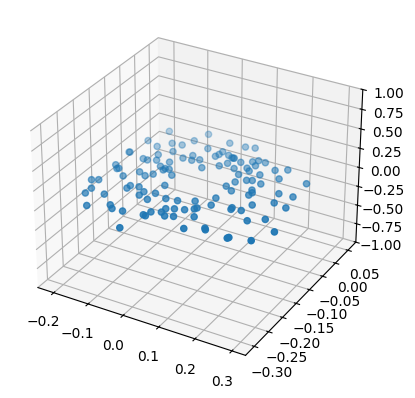

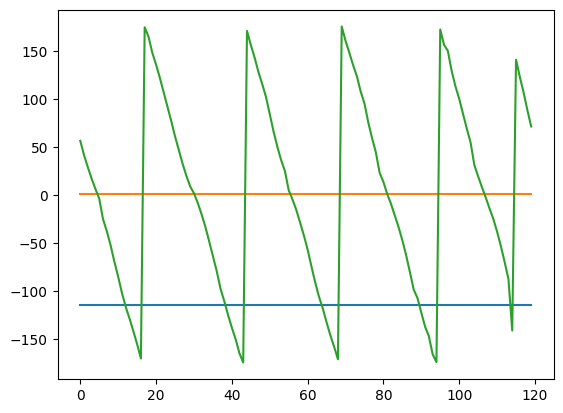

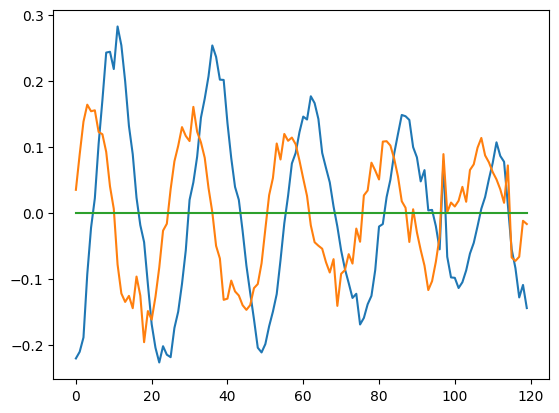

In [14]:
#transforms["frames"] = rotate_best_fit_plane(transforms["frames"])

OPENGL = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, 1]
])

points = []
euler_angle = []
for frame in transforms["frames"]:
    tf = frame["transform_matrix"]
    tf = np.array(tf).reshape(4, 4)
    #tf = np.dot(tf, OPENGL)
    points.append(tf[0:3, 3])
    r = R.from_matrix(tf[0:3, 0:3])
    euler_angle.append(r.as_euler('xyz', degrees=True))
    
points = np.array(points)
euler_angle = np.array(euler_angle)
print(euler_angle)

# Plot the points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
#Set z-axis
ax.set_zlim(-1, 1)

# Plot the euler angles with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(euler_angle[:, 0], label="x")
ax.plot(euler_angle[:, 1], label="y")
ax.plot(euler_angle[:, 2], label="z")

# Plot the points with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(points[:, 0] - points[:,0].sum()/len(points[:,0]), label="x")
ax.plot(points[:, 1] - points[:,1].sum()/len(points[:,1]), label="y")
ax.plot(points[:, 2] - points[:,2].sum()/len(points[:,2]), label="z")

plt.show()

[[ 4.49771869e+01  0.00000000e+00  0.00000000e+00]
 [ 4.49771869e+01  0.00000000e+00  7.20000000e+00]
 [ 4.49771869e+01  0.00000000e+00  1.44000000e+01]
 [ 4.49771869e+01  0.00000000e+00  2.16000000e+01]
 [ 4.49771869e+01  0.00000000e+00  2.88000000e+01]
 [ 4.49771869e+01  0.00000000e+00  3.60000000e+01]
 [ 4.49771869e+01  0.00000000e+00  4.32000000e+01]
 [ 4.49771869e+01  0.00000000e+00  5.04000000e+01]
 [ 4.49771869e+01  0.00000000e+00  5.76000000e+01]
 [ 4.49771869e+01  0.00000000e+00  6.48000000e+01]
 [ 4.49771869e+01  0.00000000e+00  7.20000000e+01]
 [ 4.49771869e+01  1.27222187e-14  7.92000000e+01]
 [ 4.49771869e+01  0.00000000e+00  8.64000000e+01]
 [ 4.49771869e+01  0.00000000e+00  9.36000000e+01]
 [ 4.49771869e+01  0.00000000e+00  1.00800000e+02]
 [ 4.49771869e+01 -1.27222187e-14  1.08000000e+02]
 [ 4.49771869e+01  0.00000000e+00  1.15200000e+02]
 [ 4.49771869e+01  0.00000000e+00  1.22400000e+02]
 [ 4.49771869e+01  0.00000000e+00  1.29600000e+02]
 [ 4.49771869e+01  0.00000000e+

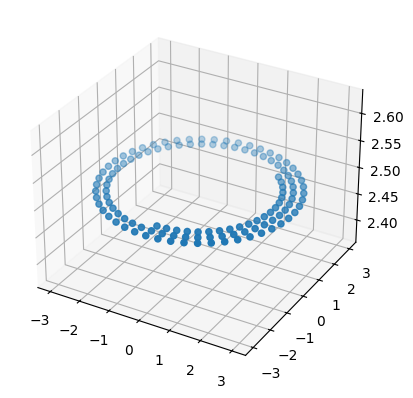

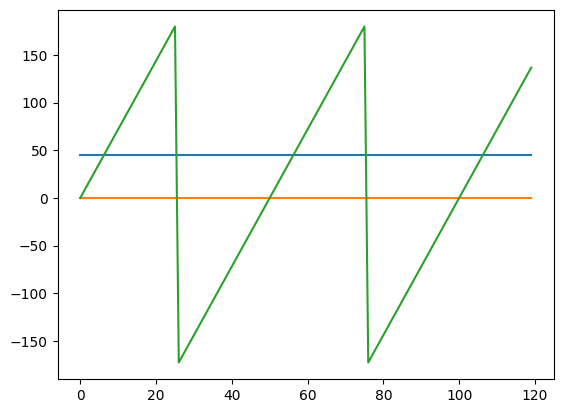

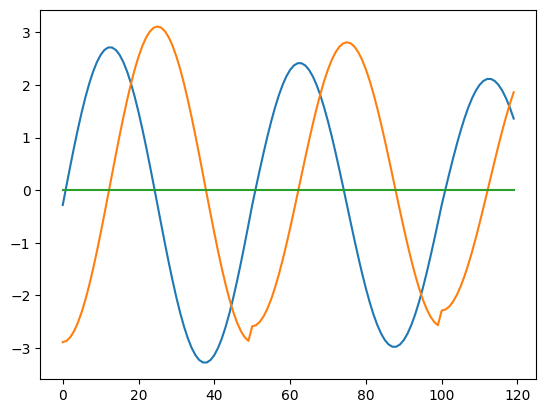

In [15]:
with open(os.path.join(DATA_PATH, "ground_truth.json"), "r") as f:
    ground_truth = json.load(f)
    
#transforms["frames"] = rotate_best_fit_plane(transforms["frames"])

ground_truth["frames"] = ground_truth["frames"][0:len(transforms["frames"])]

points = []
euler_angle = []
for frame in ground_truth["frames"]:
    tf = frame["transform_matrix"]
    tf = np.array(tf).reshape(4, 4)
    points.append(tf[0:3, 3])
    r = R.from_matrix(tf[0:3, 0:3])
    euler_angle.append(r.as_euler('xyz', degrees=True))

points = np.array(points)
euler_angle = np.array(euler_angle)
print(euler_angle)

# Plot the points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])

# Plot the euler angles with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(euler_angle[:, 0], label="x")
ax.plot(euler_angle[:, 1], label="y")
ax.plot(euler_angle[:, 2], label="z")

# Plot the points with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(points[:, 0] - points[:,0].sum()/len(points[:,0]), label="x")
ax.plot(points[:, 1] - points[:,1].sum()/len(points[:,1]), label="y")
ax.plot(points[:, 2] - points[:,2].sum()/len(points[:,2]), label="z")

plt.show()